In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs

In [2]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
plt.ion()

# GitHub API rate

In [3]:
query = "(binderhub_github_rate_limit_remaining{kubernetes_namespace=\"beta\"}[3d])"
resp = requests.get('http://prometheus.mybinder.org/api/v1/query', params={'query': query})
data = resp.json()['data']['result']

In [4]:
all_data = []
for item in data:
    all_data.append(pd.DataFrame(item['values'], columns=['time', 'value']))
all_data = pd.concat(all_data)

all_data['time'] = all_data['time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)))
all_data['value'] = all_data['value'].apply(pd.to_numeric)
all_data = all_data.set_index('time').resample('1H').mean()

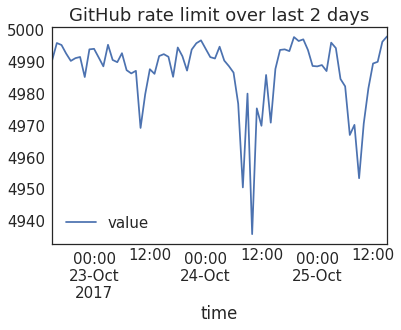

In [5]:
ax = all_data.plot()
ax.set(title="GitHub rate limit over last 2 days");

# Container names
Query containers deployed in the last N days.

In [3]:
n_days = 5
query = 'kube_pod_container_info{heritage="Tiller", container="notebook"}'
query_days = '[{n_days}d]'.format(n_days=n_days)
query += query_days
resp = requests.get('http://prometheus.mybinder.org/api/v1/query', params={'query': query})
data = resp.json()['data']['result']

In [7]:
# Collect and count the data
prefix = 'prod-v4-1'
df = {'name': [], 'ref': [], 'pod': []}
for container in data:
    pod = container['metric']['pod']
    name = container['metric']['image'].split(prefix + '-')[-1]
    name, ref = name.split(':')
    df['name'].append(name)
    df['ref'].append(ref)
    df['pod'].append(pod)
df = pd.DataFrame(df)
df = df.drop_duplicates(['pod'])

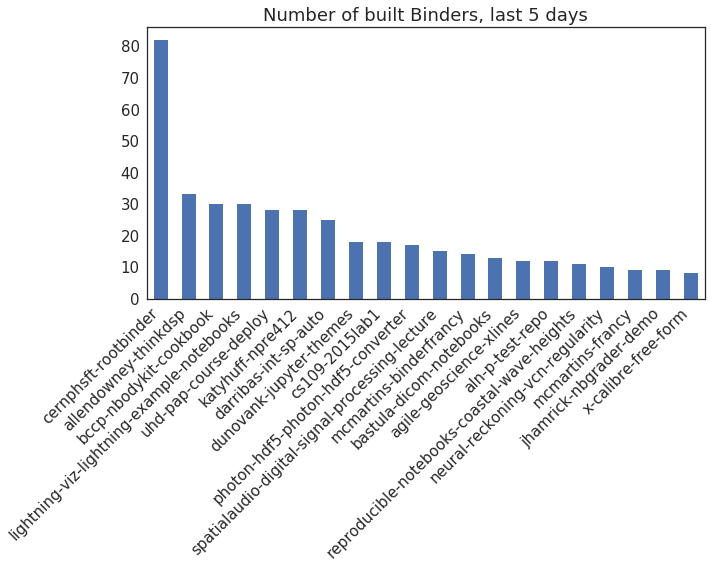

In [8]:
ax = df['name'].value_counts().iloc[:20].plot.bar(figsize=(10, 5))
ax.set(title="Number of built Binders, last {} days".format(n_days))
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');